_This is the pre-recoreded version of the live demo_

## Goal

The goal of this demo project is to find the **primary school in Munich** that has
the largest proportion of **green vegetation** in its surroundings.

For this we need to:

* Load, inspect and pre-process vector data for schools and city boundaries
* Load, inspect and pre-process raster data for trees, shrubs, and grassland
* Build a joint dataset of green vegetation
* Aggregate that raster data around each school


### Preparation

* Import necessary modules
* Define paths to input files
* Set default figure size

In [1]:
from pathlib import Path
import geopandas as gp
import xarray as xr
from IPython.display import display
from matplotlib import pyplot as plt

data_dir = Path("data")

input_files = dict(
    munich=data_dir / "munich.json",
    schools=data_dir / "schools.json",
    grassland=data_dir / "grassland_25.tiff",
    small_woody_features=data_dir / "small_woody_features_27.tiff",
    tree_cover=data_dir / "tree_cover_density_25.tiff"
)

plt.rcParams['figure.figsize'] = [12, 10]

### Load and inspect the vector data

Look at GeoJSON file first, inspect the general structure.

In [2]:
schools_df = gp.read_file(input_files["schools"])
display(schools_df)

,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,operator:type,loc_name,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry
0,relation/1536825,relation/1536825,München,58,81241,Bäckerstraße,school,school,4,Grundschule an der Bäckerstraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.46096 48.13953, 11.46060 48.13953..."
1,relation/1593473,relation/1593473,München,79,80997,Manzostraße,school,yes,None,Grundschule an der Manzostraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.48362 48.18395, 11.48322 48.18397..."
2,relation/2110129,relation/2110129,None,None,None,None,school,yes,2,Grundschule an der Walliser Straße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.48242 48.09145, 11.48222 48.09112..."
3,relation/9395978,relation/9395978,München,45,81539,Weißenseestraße,school,None,None,Grundschule an der Weißenseestraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.58645 48.10677, 11.58625 48.10684..."
4,way/13255157,way/13255157,München,35,81379,Boschetsrieder Straße,school,school,4,Grundschule an der Boschetsrieder Straße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.53578 48.10010, 11.53581 48.09998..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,node/4839684289,node/4839684289,None,None,None,None,school,None,None,Grundschule an der Zielstattstraße,...,None,None,None,None,None,None,None,None,None,POINT (11.51964 48.10276)
108,node/8117291546,node/8117291546,München,3,80992,Jenaer Straße,school,None,None,Grundschule an der Jenaer Straße,...,public,None,None,None,None,None,None,None,None,POINT (11.51746 48.18000)
109,node/8117330265,node/8117330265,München,71,81671,Grafinger Straße,school,None,None,Grundschule an der Grafinger Straße,...,public,None,None,None,None,None,None,None,None,POINT (11.61694 48.12550)
110,node/8538650321,node/8538650321,München,4,81675,Flurstraße,school,None,None,Grundschule an der Flurstraße,...,None,None,None,None,None,None,None,None,None,POINT (11.60533 48.13360)


Demo link to first entry in table, in OSM:
[https://www.openstreetmap.org/relation/1536825](https://www.openstreetmap.org/relation/1536825)

<AxesSubplot:>

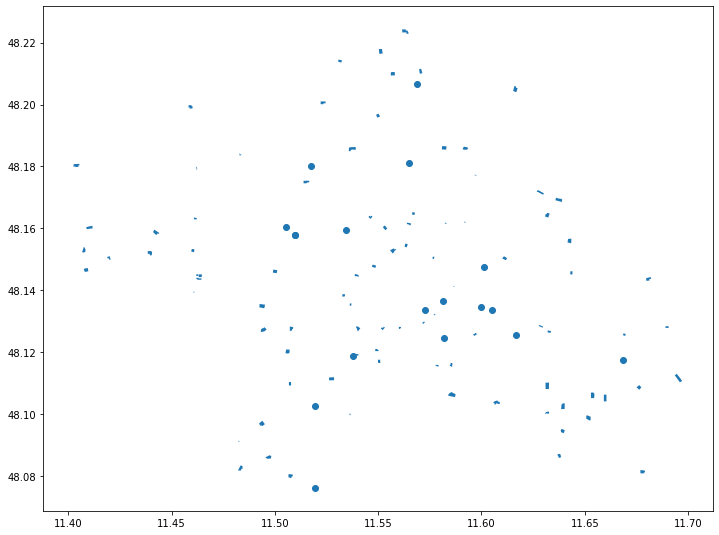

In [3]:
schools_df.plot()

In [4]:
schools_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
munich_df = gp.read_file(input_files["munich"])
display(munich_df)

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,admin_level,attribution,boundary,contact:phone,contact:website,...,name:tr,name:tzl,name:uk,old_name:sl,ref:nuts:3,type,wikidata,wikipedia,@relations,geometry
0,relation/62428,relation/62428,Area,8.00,1956,6,Open Data LH München 2017,administrative,+49 89 115,https://www.muenchen.de,...,Münih,Müntsch,Мюнхен,Monakovo,DE212,boundary,Q1726,de:München,None,"MULTIPOLYGON (((11.49077 48.07395, 11.49098 48..."
1,node/1700534808,node/1700534808,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"[ { ""role"": ""label"", ""rel"": 62428, ""reltags"": ...",POINT (11.57538 48.13711)


<AxesSubplot:>

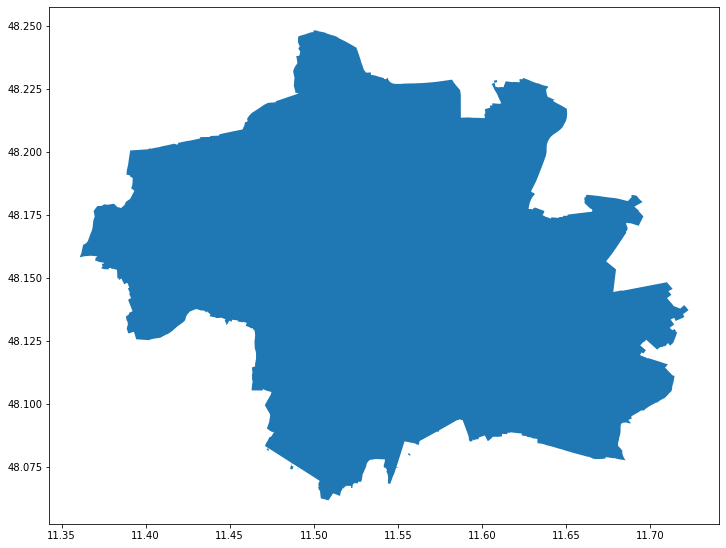

In [6]:
munich_df.plot()

### Preprocess the schools data

The dataset contains points and polygons, for some schools there are several entries.
We want to have exactly one point per school. Strategy:

* Buffer each point by 200m - for this to work, we need a metric CRS first
* Compute union of all shapes, this gives us a multipolygon
* Explode that into the distinct polygons

In [7]:
schools_df_metric = schools_df.to_crs("EPSG:3857")
display(schools_df["geometry"])
display(schools_df_metric["geometry"])

0      POLYGON ((11.46096 48.13953, 11.46060 48.13953...
1      POLYGON ((11.48362 48.18395, 11.48322 48.18397...
2      POLYGON ((11.48242 48.09145, 11.48222 48.09112...
3      POLYGON ((11.58645 48.10677, 11.58625 48.10684...
4      POLYGON ((11.53578 48.10010, 11.53581 48.09998...
                             ...                        
107                            POINT (11.51964 48.10276)
108                            POINT (11.51746 48.18000)
109                            POINT (11.61694 48.12550)
110                            POINT (11.60533 48.13360)
111                            POINT (11.59960 48.13456)
Name: geometry, Length: 112, dtype: geometry

0      POLYGON ((1275828.242 6130098.309, 1275788.479...
1      POLYGON ((1278350.831 6137512.219, 1278305.758...
2      POLYGON ((1278217.693 6122082.180, 1278195.284...
3      POLYGON ((1289797.848 6124636.092, 1289775.528...
4      POLYGON ((1284157.645 6123523.560, 1284160.250...
                             ...                        
107                      POINT (1282360.670 6123967.229)
108                      POINT (1282117.582 6136853.535)
109                      POINT (1293192.257 6127759.801)
110                      POINT (1291898.947 6129109.847)
111                      POINT (1291261.398 6129270.357)
Name: geometry, Length: 112, dtype: geometry

CRS reference: [https://epsg.io/3857](https://epsg.io/3857)

> This is projected coordinate system used for rendering maps in Google Maps, OpenStreetMap, etc.


<AxesSubplot:>

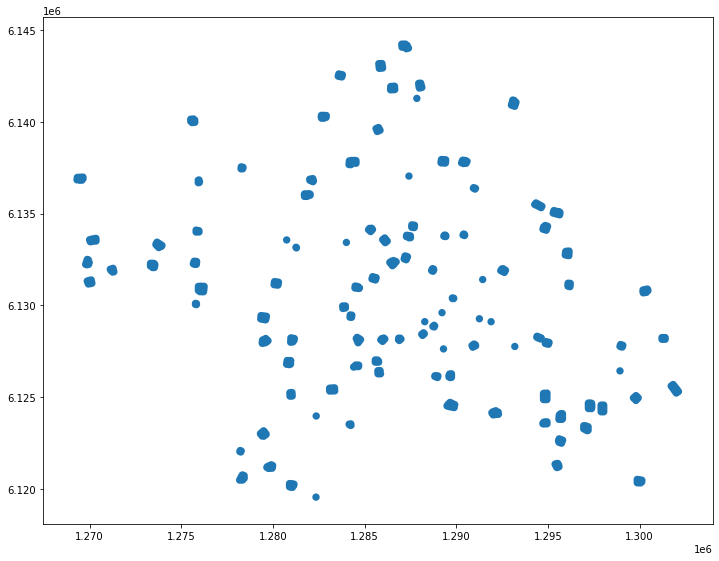

In [8]:
schools_buffered = schools_df_metric.buffer(200)
schools_buffered.plot()

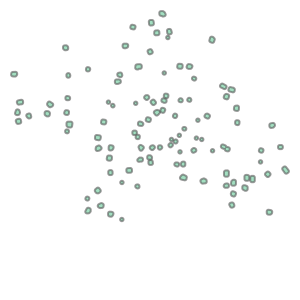

MULTIPOLYGON (((1282503.962459266 6119415.945777977, 1282490.781724831 6119401.403078572, 1282476.239025427 6119388.222344137, 1282460.474415198 6119376.530512349, 1282443.639715959 6119366.44018194, 1282425.897055067 6119358.048528307, 1282407.417304045 6119351.436367663, 1282388.378432997 6119346.667378728, 1282368.96379666 6119343.787489475, 1282349.360368594 6119342.824434809, 1282329.756940528 6119343.787489475, 1282310.342304191 6119346.667378728, 1282291.303433143 6119351.436367663, 1282272.823682121 6119358.048528307, 1282255.081021229 6119366.44018194, 1282238.24632199 6119376.530512349, 1282222.481711761 6119388.222344137, 1282207.939012357 6119401.403078572, 1282194.758277921 6119415.945777977, 1282183.066446133 6119431.710388205, 1282172.976115724 6119448.545087445, 1282164.584462092 6119466.287748337, 1282157.972301447 6119484.767499358, 1282153.203312513 6119503.806370406, 1282150.323423259 6119523.221006744, 1282149.360368594 6119542.824434809, 1282150.323423259 6119562.

In [9]:
schools_union = schools_buffered.unary_union
display(schools_union)
print(schools_union)

In [10]:
separated_schools = gp.GeoDataFrame(geometry=[schools_union]).explode()
display(separated_schools)

geometry
0 0    POLYGON ((1282503.962 6119415.946, 1282490.782...
  1    POLYGON ((1280781.133 6119947.858, 1280766.889...
  2    POLYGON ((1279498.170 6121062.340, 1279489.154...
  3    POLYGON ((1282515.273 6123840.350, 1282502.092...
  4    POLYGON ((1278189.614 6120889.954, 1278203.577...
...                                                  ...
  99   POLYGON ((1283413.963 6142707.251, 1283423.001...
  100  POLYGON ((1286168.852 6143074.821, 1286178.715...
  101  POLYGON ((1288034.054 6141212.913, 1288025.662...
  102  POLYGON ((1287779.033 6141867.749, 1287777.152...
  103  POLYGON ((1287298.356 6144435.683, 1287316.698...

[104 rows x 1 columns]

In [11]:
school_points = gp.GeoDataFrame(geometry=separated_schools.centroid)
display(school_points)

geometry
0 0    POINT (1282349.360 6119542.824)
  1    POINT (1281012.768 6120187.695)
  2    POINT (1279842.034 6121194.003)
  3    POINT (1282360.670 6123967.229)
  4    POINT (1278320.779 6120593.851)
...                                ...
  99   POINT (1283675.690 6142540.631)
  100  POINT (1285875.574 6143061.119)
  101  POINT (1287849.278 6141289.450)
  102  POINT (1288027.798 6141988.002)
  103  POINT (1287199.401 6144130.774)

[104 rows x 1 columns]

<AxesSubplot:>

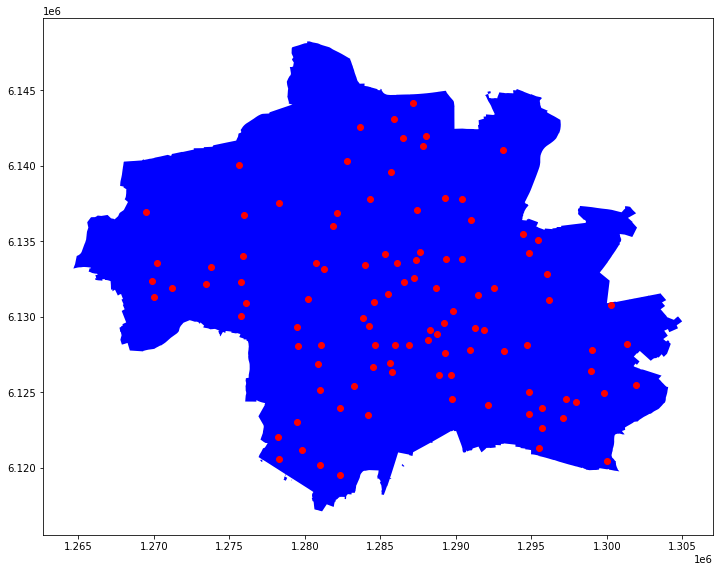

In [12]:
munich_df_metric = munich_df.to_crs("EPSG:3857")

munich_df_metric.plot(color="blue")
school_points.plot(ax=plt.gca(), color='red')

### Load and inspect the raster data

In [13]:
tree_cover = xr.open_rasterio(input_files["tree_cover"])
print(tree_cover)


<xarray.DataArray (band: 1, y: 1245, x: 1612)>
[2006940 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Attributes:
    transform:      (25.00772334211627, 0.0, 1264675.9106559341, 0.0, -24.995...
    crs:            +init=epsg:3857
    res:            (25.00772334211627, 24.995318193712)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic


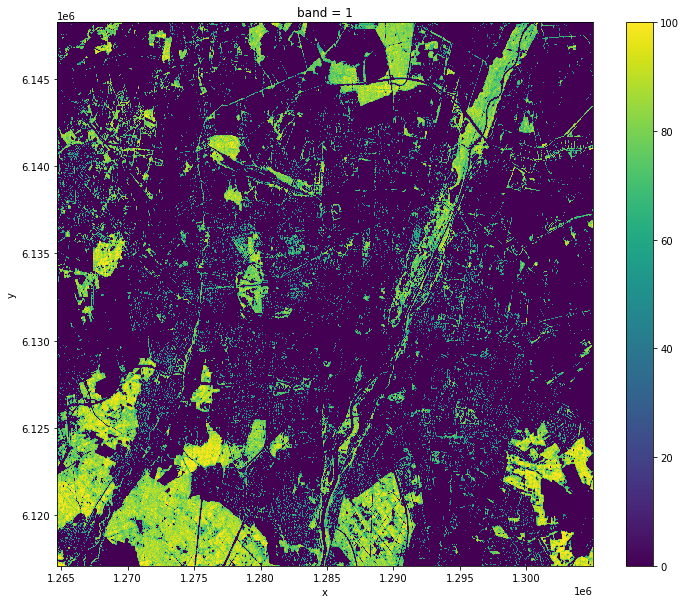

In [14]:
tree_cover.plot()

In [15]:
print(tree_cover.min(), tree_cover.max(), tree_cover.median())

<xarray.DataArray ()>
array(0, dtype=uint8) <xarray.DataArray ()>
array(100, dtype=uint8) <xarray.DataArray ()>
array(0.)


We can do min/max/mean... across one or several dimensions

In [16]:
print(tree_cover.mean(dim='x'))

<xarray.DataArray (band: 1, y: 1245)>
array([[19.06947891, 19.23325062, 19.43300248, ..., 39.63647643,
        39.90632754, 40.69168734]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06


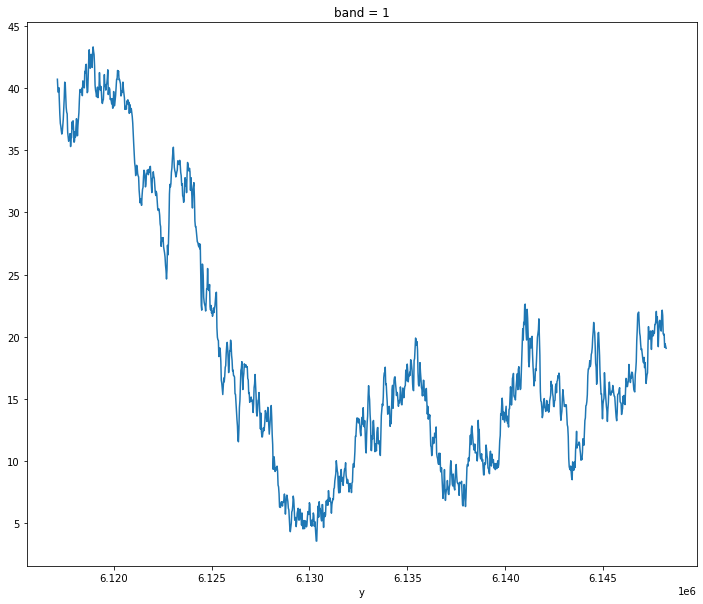

In [17]:
tree_cover.mean(dim='x').plot()

-> it's greener in the south.

Now make a binary version, threshold at 25% tree cover:

In [18]:
tree_cover_binary = tree_cover > 25

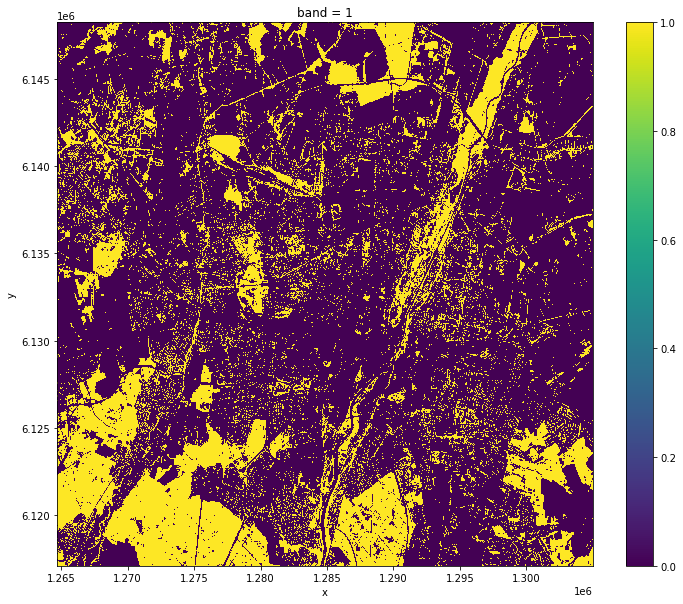

In [19]:
tree_cover_binary.plot()

Load grassland data, I already know that this is binary (but may have 255 as missing
data value, so binarize anyway).

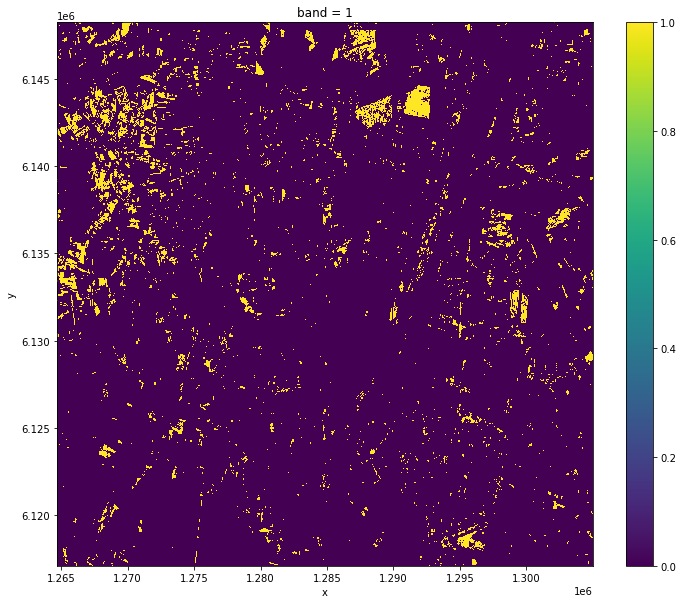

In [20]:
grassland = xr.open_rasterio(input_files["grassland"])
grassland.plot()

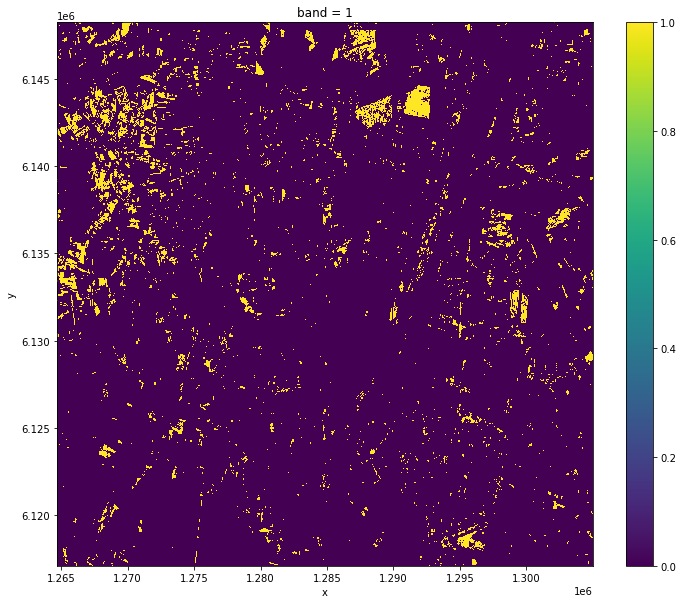

In [21]:
grassland_binary = grassland == 1
grassland_binary.plot()

Also load shrubs data

<xarray.DataArray (band: 1, y: 1153, x: 1493)>
[1721429 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Attributes:
    transform:      (27.000971217341885, 0.0, 1264675.9106559341, 0.0, -26.98...
    crs:            +init=epsg:3857
    res:            (27.000971217341885, 26.989740807607493)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic


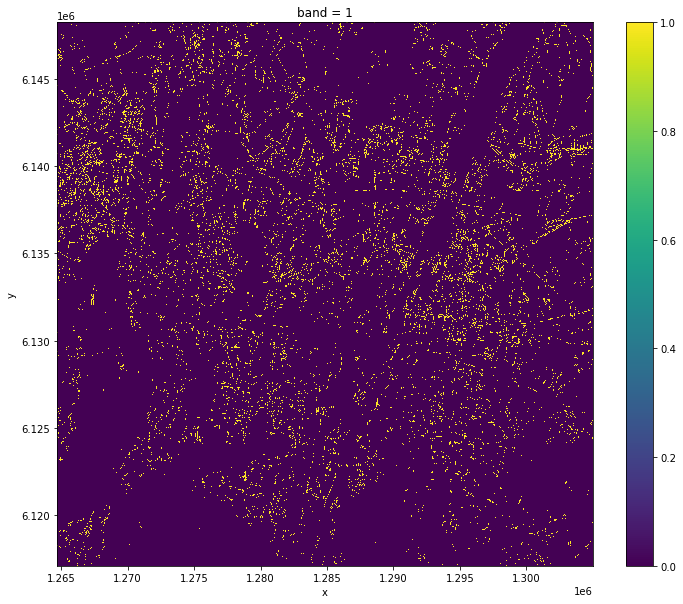

In [22]:
shrubs = xr.open_rasterio(input_files["small_woody_features"])
print(shrubs)
shrubs_binary = shrubs == 1
shrubs_binary.plot()

Stuff DataArrays into a dataset.

xarray automatically aligns the dimesions (the grid).

In [23]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 1612, y: 1245)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Data variables:
    trees    (band, y, x) bool False False False False ... True True True True
    grass    (band, y, x) bool False False False False ... False False False


In [24]:
greenery.sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    trees    int64 510068
    grass    int64 99233

Try to add the scrubs... this breaks the grid! More points, lots of NaNs!

In [25]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary, shrubs=shrubs_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 3105, y: 2397)
Coordinates:
  * y        (y) float64 6.117e+06 6.117e+06 6.117e+06 ... 6.148e+06 6.148e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
  * band     (band) int64 1
Data variables:
    trees    (band, y, x) float64 1.0 nan 1.0 nan 1.0 ... 0.0 nan 0.0 nan 0.0
    grass    (band, y, x) float64 0.0 nan 0.0 nan 0.0 ... 0.0 nan 0.0 nan 0.0
    shrubs   (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


I intentionally downloaded the shrubs on a different resolution, so we need to resample.

Let's try... fails at first, because xarray tries to interpolate on the 'band' dimension which
has only one point. Squeeze it out, then it works.

In [27]:
shrubs_resampled = shrubs.interp_like(tree_cover, method='nearest')

ValueError: x and y arrays must have at least 2 entries

In [28]:
shrubs_resampled = shrubs.squeeze('band').interp_like(tree_cover, method='nearest')
shrubs_binary = shrubs_resampled == 1

In [29]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary, shrubs=shrubs_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 1612, y: 1245)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Data variables:
    trees    (band, y, x) bool False False False False ... True True True True
    grass    (band, y, x) bool False False False False ... False False False
    shrubs   (y, x) bool False False False False ... False False False False


Make a joint binary DataArray of green pixels

<xarray.DataArray (band: 1, y: 1245, x: 1612)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06


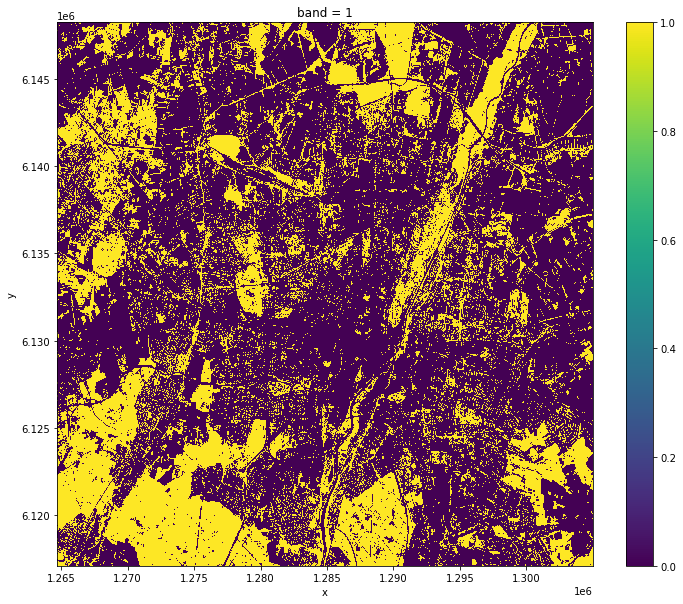

In [30]:
any_greenery = greenery["trees"] | greenery["grass"] | greenery["shrubs"]
print(any_greenery)
any_greenery.plot()

## Now determine green pixels around schools

Very simple method: select a box of +- 500 meters around each school, count green pixels.

In [31]:
school_greenery = gp.GeoDataFrame(dict(green_pixels=float("nan"), geometry=school_points["geometry"].values))
print(school_greenery)

     green_pixels                         geometry
0             NaN  POINT (1282349.360 6119542.824)
1             NaN  POINT (1281012.768 6120187.695)
2             NaN  POINT (1279842.034 6121194.003)
3             NaN  POINT (1282360.670 6123967.229)
4             NaN  POINT (1278320.779 6120593.851)
..            ...                              ...
99            NaN  POINT (1283675.690 6142540.631)
100           NaN  POINT (1285875.574 6143061.119)
101           NaN  POINT (1287849.278 6141289.450)
102           NaN  POINT (1288027.798 6141988.002)
103           NaN  POINT (1287199.401 6144130.774)

[104 rows x 2 columns]


**Attention:** Note selection `(y + r, y - r)` below! `y` coordinate order is descending.

In [36]:
r = 500
for idx, point in school_greenery["geometry"].items():
    x, y = point.coords[0]
    pixel_selection = any_greenery.sel(
        dict(x=slice(x - r, x + r), y=slice(y + r, y - r))
    )
    school_greenery.loc[idx, "green_pixels"] = pixel_selection.values.sum()

    # add later, this is an example for assertion testing:
    assert pixel_selection.shape[0] == 1
    assert 40 <= pixel_selection.shape[1] <= 41
    assert 40 <= pixel_selection.shape[2] <= 41
    assert school_greenery.loc[idx, "green_pixels"] >= 0
    assert school_greenery.loc[idx, "green_pixels"] < 40 * 40

print(school_greenery)

     green_pixels                         geometry
0           354.0  POINT (1282349.360 6119542.824)
1           333.0  POINT (1281012.768 6120187.695)
2           287.0  POINT (1279842.034 6121194.003)
3           568.0  POINT (1282360.670 6123967.229)
4           300.0  POINT (1278320.779 6120593.851)
..            ...                              ...
99           63.0  POINT (1283675.690 6142540.631)
100         353.0  POINT (1285875.574 6143061.119)
101         428.0  POINT (1287849.278 6141289.450)
102         505.0  POINT (1288027.798 6141988.002)
103        1098.0  POINT (1287199.401 6144130.774)

[104 rows x 2 columns]


In [37]:
print(school_greenery["green_pixels"].describe())

count     104.000000
mean      272.596154
std       172.920629
min        19.000000
25%       144.500000
50%       253.000000
75%       375.500000
max      1098.000000
Name: green_pixels, dtype: float64


<AxesSubplot:>

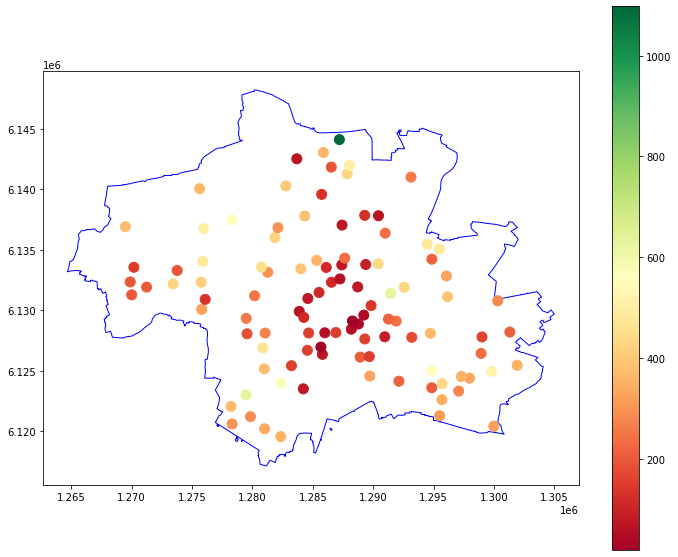

In [38]:
munich_df_metric.iloc[[0]].plot(facecolor="white", edgecolor="blue")
school_greenery.plot(column="green_pixels", ax=plt.gca(), legend=True, cmap='RdYlGn', markersize=100)

## Example of a very simple data consistency check

In [39]:
def check_results(s):
    assert len(s) > 100
    assert len(s) < 500
    assert s.min() > 10
    assert s.max() > 40 * 40 / 2
    assert s.median() > 100
    assert s.median() < 400

check_results(school_greenery["green_pixels"])

Try what happens if you assumed that the grid was in km, setting the radius above from `500` to `0.5`,
then compute the green pixels and run the consistency check.


## Addendum: join up greenery data with original DataFrame


In [40]:
school_greenery.crs = "EPSG:3857"
schools_with_buffered_geo = schools_df.copy()
schools_with_buffered_geo.crs = "EPSG:3857"
schools_with_buffered_geo["geometry"] = schools_buffered
joint = gp.sjoin(schools_with_buffered_geo, school_greenery, how="left", op="intersects").sort_values(by="green_pixels")
display(joint.head(5))
display(joint.tail(5))

,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry,index_right,green_pixels
90,way/856493188,way/856493188,München,35,81371,Implerstraße,school,None,None,Grundschule an der Implerstraße,...,None,None,None,None,None,None,None,"POLYGON ((1285596.448 6127223.830, 1285625.048...",71,19.0
100,node/1576527684,node/1576527684,None,None,None,None,school,None,None,Theresia-Gerhardinger-Grundschule am Anger,...,None,None,None,None,None,None,None,"POLYGON ((1288480.930 6129111.515, 1288479.967...",76,19.0
41,way/108338026,way/108338026,München,27,80469,Klenzestraße,school,None,None,Grundschule am Gärtnerplatz,...,None,None,None,None,None,None,None,"POLYGON ((1288720.150 6128640.016, 1288715.435...",75,40.0
104,node/2654727020,node/2654727020,München,21,80539,Herrnstraße,school,None,None,Grundschule an der Herrnstraße,...,None,None,None,None,None,None,none,"POLYGON ((1289422.448 6129601.728, 1289421.485...",77,44.0
37,way/100318418,way/100318418,None,None,None,None,school,None,None,Grundschule an der Klenzestraße,...,None,None,None,None,None,None,None,"POLYGON ((1287989.834 6128580.115, 1288002.791...",70,48.0


,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry,index_right,green_pixels
62,way/156638768,way/156638768,None,None,None,None,school,None,None,Grundschule am Strehleranger,...,None,None,None,None,None,None,None,"POLYGON ((1294900.302 6124662.344, 1294854.033...",55,563.0
107,node/4839684289,node/4839684289,None,None,None,None,school,None,None,Grundschule an der Zielstattstraße,...,None,None,None,None,None,None,None,"POLYGON ((1282560.670 6123967.229, 1282559.707...",3,568.0
65,way/162202144,way/162202144,München,6,81476,Berner Straße,school,None,None,Grundschule an der Berner Straße,...,None,None,None,None,None,None,None,"POLYGON ((1279157.911 6123113.446, 1279165.558...",6,629.0
98,node/1405087466,node/1405087466,None,None,None,None,school,None,None,Bilinguale Grundschule Phorms,...,None,None,None,None,None,None,None,"POLYGON ((1291640.823 6131409.933, 1291639.860...",85,629.0
56,way/144346589,way/144346589,None,20,None,Thelottstraße,school,None,None,Grundschule mit Tagesheim an der Thelottstraße 20,...,None,None,None,None,None,None,None,"POLYGON ((1287025.355 6144446.564, 1287219.274...",103,1098.0
